In [1]:
import torch   # <-- missing import
from torchvision import datasets, transforms
from torch.utils.data import random_split
import os
from torchvision import datasets, transforms
from torch.utils.data import random_split

# Path to dataset
data_dir = "/kaggle/input/cucumber-disease/cucumber_disease"

# Transformations (resize + tensor + normalization for VGG16/Inception)
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # standard size for VGG16/Inception
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Dataset sizes
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)   # 80%
val_size   = int(0.1 * dataset_size)   # 10%
test_size  = dataset_size - train_size - val_size  # remaining 10%

# Split reproducibly into train, val, test
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)   # fix random seed
)

# Class names
class_names = dataset.classes
print("Classes:", class_names)
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Classes: ['Anthracnose', 'Bacterial Wilt', 'Belly Rot', 'Downy Mildew', 'Fresh Cucumber', 'Fresh Leaf', 'Pythium Fruit Rot']
Train samples: 903, Val samples: 112, Test samples: 114


In [2]:
from torch.utils.data import DataLoader

# ======================
# Hyperparameters
# ======================
batch_size = 32
epochs = 20
image_size = 224  

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [3]:
import torch
import torch.nn as nn
import timm  # modern replacement for pretrainedmodels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Load pretrained InceptionV4
# -----------------------------
model = timm.create_model("inception_v4", pretrained=True)

# -----------------------------
# Replace classifier (correct layer for timm InceptionV4)
# -----------------------------
num_classes = 7
in_features = model.get_classifier().in_features   # timm API
model.classif = nn.Linear(in_features, num_classes)  # <-- FIXED here

model = model.to(device)

# -----------------------------
# Loss & Optimizer
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=0.0001
)


model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

In [4]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # -----------------------------
        # Training phase
        # -----------------------------
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, leave=False)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)   # InceptionV4 (no aux outputs)

            loss = criterion(outputs, labels)
            preds = torch.max(outputs, 1)[1]

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_description(f"Train Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item(), acc=correct/total)

        train_loss = running_loss / total
        train_acc = correct / total

        # -----------------------------
        # Validation phase
        # -----------------------------
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                preds = torch.max(outputs, 1)[1]
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history


# -----------------------------
# Train the model
# -----------------------------
history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs, device)



Epoch 1/20


Epoch 1/20 - Train Loss: 3.9194, Train Acc: 0.4109, Val Loss: 0.8779, Val Acc: 0.8125

Epoch 2/20


Epoch 2/20 - Train Loss: 0.3257, Train Acc: 0.9380, Val Loss: 2.5308, Val Acc: 0.8482

Epoch 3/20


Epoch 3/20 - Train Loss: 0.1157, Train Acc: 0.9690, Val Loss: 1.0719, Val Acc: 0.8839

Epoch 4/20


Epoch 4/20 - Train Loss: 0.0805, Train Acc: 0.9856, Val Loss: 2.4400, Val Acc: 0.9107

Epoch 5/20


Epoch 5/20 - Train Loss: 0.0641, Train Acc: 0.9834, Val Loss: 0.7194, Val Acc: 0.9196

Epoch 6/20


Epoch 6/20 - Train Loss: 0.0577, Train Acc: 0.9900, Val Loss: 0.5220, Val Acc: 0.8750

Epoch 7/20


Epoch 7/20 - Train Loss: 0.0588, Train Acc: 0.9889, Val Loss: 0.5399, Val Acc: 0.8929

Epoch 8/20


Epoch 8/20 - Train Loss: 0.0530, Train Acc: 0.9889, Val Loss: 0.4955, Val Acc: 0.8661

Epoch 9/20


Epoch 9/20 - Train Loss: 0.0437, Train Acc: 0.9878, Val Loss: 0.5848, Val Acc: 0.9018

Epoch 10/20


Epoch 10/20 - Train Loss: 0.0393, Train Acc: 0.9900, Val Loss: 0.4707, Val Acc: 0.8929

Epoch 11/20


Epoch 11/20 - Train Loss: 0.0302, Train Acc: 0.9922, Val Loss: 0.6520, Val Acc: 0.8482

Epoch 12/20


Epoch 12/20 - Train Loss: 0.0260, Train Acc: 0.9945, Val Loss: 0.5743, Val Acc: 0.8839

Epoch 13/20


Epoch 13/20 - Train Loss: 0.0272, Train Acc: 0.9934, Val Loss: 0.5501, Val Acc: 0.8929

Epoch 14/20


Epoch 14/20 - Train Loss: 0.0168, Train Acc: 0.9956, Val Loss: 0.5639, Val Acc: 0.8750

Epoch 15/20


Epoch 15/20 - Train Loss: 0.0206, Train Acc: 0.9945, Val Loss: 0.5695, Val Acc: 0.8839

Epoch 16/20


Epoch 16/20 - Train Loss: 0.0161, Train Acc: 0.9934, Val Loss: 0.5258, Val Acc: 0.8839

Epoch 17/20


Epoch 17/20 - Train Loss: 0.0489, Train Acc: 0.9878, Val Loss: 0.4737, Val Acc: 0.9018

Epoch 18/20


Epoch 18/20 - Train Loss: 0.0349, Train Acc: 0.9911, Val Loss: 0.4154, Val Acc: 0.9018

Epoch 19/20


Epoch 19/20 - Train Loss: 0.0445, Train Acc: 0.9867, Val Loss: 0.4639, Val Acc: 0.9107

Epoch 20/20


Epoch 20/20 - Train Loss: 0.0259, Train Acc: 0.9956, Val Loss: 0.4691, Val Acc: 0.8929


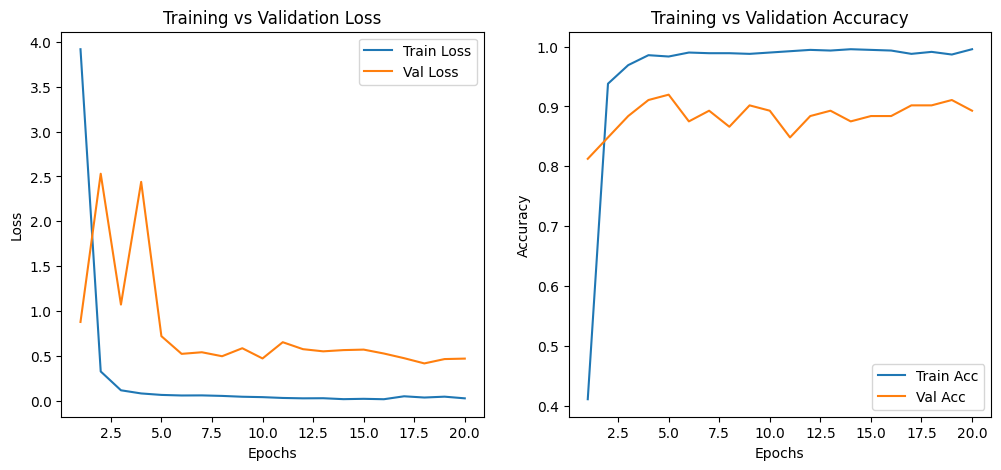

In [5]:
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    plt.show()

plot_history(history)


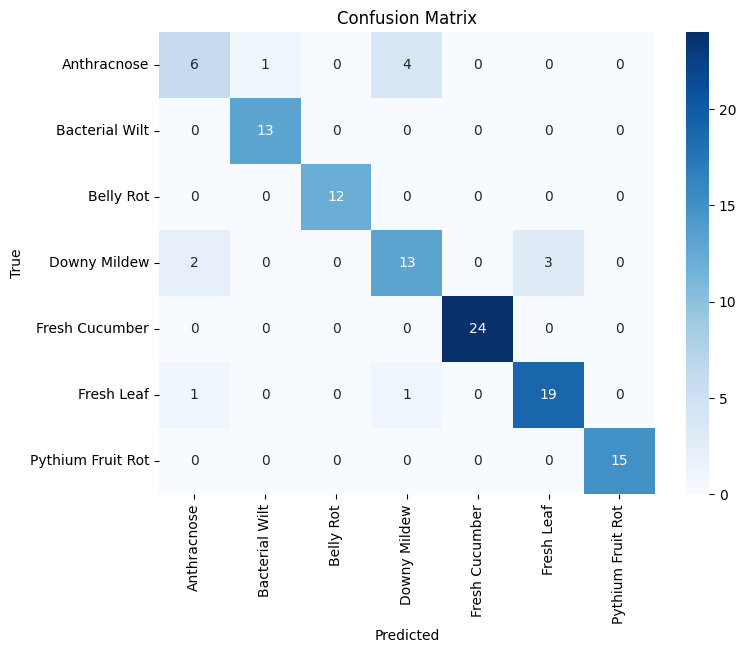


Classification Report:

                   precision    recall  f1-score   support

      Anthracnose       0.67      0.55      0.60        11
   Bacterial Wilt       0.93      1.00      0.96        13
        Belly Rot       1.00      1.00      1.00        12
     Downy Mildew       0.72      0.72      0.72        18
   Fresh Cucumber       1.00      1.00      1.00        24
       Fresh Leaf       0.86      0.90      0.88        21
Pythium Fruit Rot       1.00      1.00      1.00        15

         accuracy                           0.89       114
        macro avg       0.88      0.88      0.88       114
     weighted avg       0.89      0.89      0.89       114



In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def evaluate_model(model, test_loader, class_names, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Test
evaluate_model(model, test_loader, class_names, device)
